In [149]:
import pandas as pd
import re
import tiktoken
import numpy as np
import pickle
import openai

from tqdm.notebook import tqdm
from nltk.tokenize import sent_tokenize
from pathlib import Path
from PyPDF2 import PdfReader
from matplotlib import pyplot as plt


In [194]:

encoding = tiktoken.encoding_for_model('text-davinci-003')

def count_tokens(text):
    return len(encoding.encode(text))

def reduce_long(long_text, long_text_tokens=False, max_len=590):
    if not long_text_tokens:
        long_text_tokens = count_tokens(long_text)
    if long_text_tokens > max_len:
        sentences = sent_tokenize(long_text.replace("\n", " "))
        ntokens = 0
        for i, sentence in enumerate(sentences):
            ntokens += 1 + count_tokens(sentence)
            if ntokens > max_len:
                return ". ".join(sentences[:i]) + "."
    return long_text

def extract_sections(source, text, max_len=1500):
    if len(text) == 0:
        return []
    sections = []
    headings = []
    heading = ""
    section = ""
    for l in text.split('\n'):
        l = l.strip()
        name = re.findall('^(#{1,2}\s(.*))', l)
        if len(name) == 1:
            heading = name[0][1]
            l = l.removeprefix(name[0][0])
        section += (l + '\n').strip()
    if len(section) > 0:
        headings.append(heading)
        sections.append(section)
    assert len(headings) == len(sections)

    counts = [count_tokens(s) + count_tokens(h) for h, s in zip(headings, sections)]
    
    results = []
    for h, s, c in zip(headings, sections, counts):
        if c > max_len:
            s = reduce_long(s, max_len)
            c = count_tokens(s)
        results.append((source, h, s, c))
    return results


dir = "../../localdata/sorare-notion/text-only"
ps = list(Path(dir).glob("**/*.md"))

pages = []
# ps = ps[:1]
for p in ps:
    content = ""
    with open(p, "r") as fd:
        text = fd.read()
        file_name = str(p).removeprefix(dir+"/")          
        pages.extend(extract_sections(str(file_name), text))
len(pages)

612

In [195]:
df = pd.DataFrame(pages, columns=["source", "heading", "content", "tokens"])
df = df[df.tokens>40]
df = df.set_index(["source", "heading"])
df.head(5)

,,content,tokens
source,heading,,
Rickert OOO bfccdfa1b0cc476dacd560a1323cbf08.md,Rickert OOO,"*May be missing things, think this is close to...",1143
Business Development 87de3306dd7a4e119068567e0ddc8874.md,Other:,<aside>💡 This page gather all our processes an...,803
MLB f1984142190041aa8c237f85743c902e.md,MLB,### Team MLB[Team Roster](MLB%20f1984142190041...,756
Crypto ffd4609240e144bbad3354c4e6c1cb23.md,Crypto,[Ethereum merge](Crypto%20ffd4609240e144bbad33...,62
Sorare blockchain event endpoint d6c7e7c2ce184735ae596c450d1f257e.md,Other,Sorare was initially operating on Ethereum Lay...,566


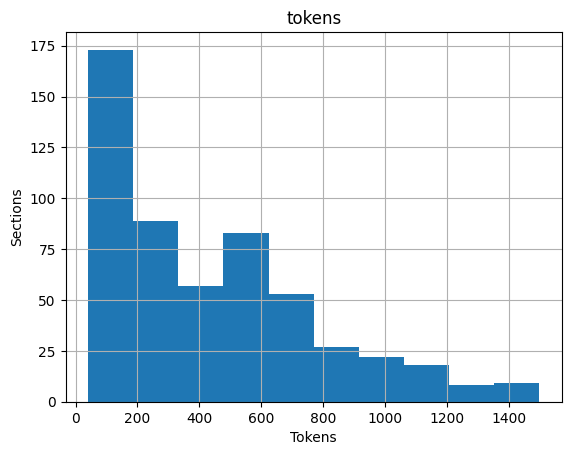

In [196]:
df[['tokens']].hist()
plt.xlabel('Tokens')
plt.ylabel('Sections')
plt.show()

In [201]:
COMPLETIONS_MODEL = "text-davinci-003"
EMBEDDING_MODEL = "text-embedding-ada-002"

def get_embedding(text, model=EMBEDDING_MODEL):
    result = openai.Embedding.create(
      model=model,
      input=text
    )
    return result["data"][0]["embedding"]

def compute_doc_embeddings(df):
    return {
        (idx): get_embedding(r.content) for idx, r in tqdm(df.iterrows(), total=len(df))
    }


In [202]:
document_embeddings = compute_doc_embeddings(df)

  0%|          | 0/539 [00:00<?, ?it/s]

In [203]:
example_entry = list(document_embeddings.items())[0]
# print(example_entry)
print(f"{example_entry[0]} : {example_entry[1][:5]}... ({len(example_entry[1])} entries)")

('Rickert OOO bfccdfa1b0cc476dacd560a1323cbf08.md', 'Rickert OOO') : [-0.0016666308511048555, -0.005373339634388685, -0.009134677238762379, -0.02477467805147171, -0.02696700021624565]... (1536 entries)


In [204]:
def vector_similarity(x, y):
    return np.dot(np.array(x), np.array(y))

def order_document_sections_by_query_similarity(query, contexts):
    query_embedding = get_embedding(query)
    document_similarities = sorted([
        (vector_similarity(query_embedding, doc_embedding), doc_index) for doc_index, doc_embedding in contexts.items()
    ], reverse=True)    
    return document_similarities


In [205]:
order_document_sections_by_query_similarity("what is rickert doing exactly?", document_embeddings)[:5]

[(0.7884052686592682,
  ('Rickert OOO bfccdfa1b0cc476dacd560a1323cbf08.md', 'Rickert OOO')),
 (0.7678320087041294,
  ('Eng Management Notes 148110389bb749a0bd6a739da9201051/MLB ↔ Platform 5d0aac6ab1c04109a5a7d054e60116f4.md',
   'Questions')),
 (0.7461937023052492,
  ('Product 928cf26963414baa9509dd32289d7541/External Consultants 35c0cc0603ca473ea1ee7854c13e04c2.md',
   'External Consultants')),
 (0.7455394724869192,
  ('Eng Management Notes 148110389bb749a0bd6a739da9201051/Contractor Notes db135c9497e64b8c91dd8f4dcc61e8a7.md',
   'Contractor Notes')),
 (0.7409580408114178,
  ('Eng Management Notes 148110389bb749a0bd6a739da9201051/Hallie b641517f68c84a68aeb604d24bcea5a9.md',
   'Hallie'))]

In [218]:
MAX_SECTION_LEN = 3000
SEPARATOR = "\n* "
separator_len = len(encoding.encode(SEPARATOR))


In [217]:
def construct_prompt(question, context_embeddings, df):
    most_relevant_document_sections = order_document_sections_by_query_similarity(question, context_embeddings)
    chosen_sections = []
    chosen_sections_len = 0
    chosen_sections_indexes = []
    for _, section_index in most_relevant_document_sections:
        # add contexts until we run out of space
        document_section = df.loc[section_index]
        chosen_sections_len += document_section.tokens + separator_len
        if chosen_sections_len > MAX_SECTION_LEN:
            break
            
        chosen_sections.append(SEPARATOR + document_section.content.replace("\n", " "))
        chosen_sections_indexes.append(str(section_index))
            
    print(f"Selected {len(chosen_sections)} document sections:")
    print("\n".join(chosen_sections_indexes))    
    header = """Answer the question as truthfully as possible using the provided context, and if the answer is not contained within the text below, say "I don't know."\n\nContext:\n"""
    return header + "".join(chosen_sections) + "\n\n Q: " + question + "\n A:"


In [208]:
COMPLETIONS_API_PARAMS = {
    # We use temperature of 0.0 because it gives the most predictable, factual answer.
    "temperature": 0.0,
    "max_tokens": 300,
    "model": COMPLETIONS_MODEL,
}

In [213]:
def answer_query_with_context(
    query: str,
    df: pd.DataFrame,
    document_embeddings: dict[(str, str), np.array],
    show_prompt: bool = False
) -> str:
    prompt = construct_prompt(
        query,
        document_embeddings,
        df
    )
    
    if show_prompt:
        print(prompt)

    response = openai.Completion.create(
                prompt=prompt,
                **COMPLETIONS_API_PARAMS
            )

    return response["choices"][0]["text"].strip(" \n")

def ask(q, df=df, embeds=document_embeddings):
    answer = answer_query_with_context(q, df, embeds)
    print(f"\nQ: {q}\nA: {answer}")

In [219]:
ask("is NPS a good or bad KPI?")

Selected 6 document sections:
('Scratchpad 9d9ba90773b344678e570406b4dfc110/NPS is a poor KPI 66b18634a05d42489d81543ea7479f22.md', 'Appendix')
('Sorare Key Indicators 2aa9b1a126b4414fa1edff315b3643fd.md', 'KPIs')
('Scratchpad 9d9ba90773b344678e570406b4dfc110.md', 'Scratchpad')
('Leadership team 6d8774ea35fb4481ba34dac53c50e15c/Draft Highly functional Product & Engineering orga c24058d883b845e5b7849643a07f8375.md', 'Draft: Highly functional Product & Engineering organisations')
('Data 8bc7fd89459546249ab5371f64a7bb65/Main KPIs and definition b585950f2b97448a921206dfe739e21a.md', 'Main KPIs and definition')
('Leadership team 6d8774ea35fb4481ba34dac53c50e15c/1-1 Meeting notes 85a83acf18004055848ebdb9e0c0bec1.md', 'Old format (history)')

Q: is NPS a good or bad KPI?
A: NPS is a poor KPI.


In [223]:
ask("why is NPS a poor KPI?")

Selected 5 document sections:
('Scratchpad 9d9ba90773b344678e570406b4dfc110/NPS is a poor KPI 66b18634a05d42489d81543ea7479f22.md', 'Appendix')
('Scratchpad 9d9ba90773b344678e570406b4dfc110.md', 'Scratchpad')
('Sorare Key Indicators 2aa9b1a126b4414fa1edff315b3643fd.md', 'KPIs')
('Data 8bc7fd89459546249ab5371f64a7bb65/Main KPIs and definition b585950f2b97448a921206dfe739e21a.md', 'Main KPIs and definition')
('Eng Management Notes 148110389bb749a0bd6a739da9201051/How to GM How Squads Run cb3efff9f6804ccf8f407052b7a955be.md', 'Growth Process')

Q: why is NPS a poor KPI?
A: NPS is a poor KPI because it is an unscientific, varied, and easily gamed metric that is harmful if used as a key business metric. It is unclear how it rolls up to the business metrics that actually matter, it suffers from an unacceptable amount of variance, making interpretation misleading at best, and it effectively pretends that noise is science.


In [1]:
ask("what is Adrien Montfort working on?")

NameError: name 'ask' is not defined